# Model Transparency for Big Data Analytics for Intrusion Detection System: Framework for Defining AI Trustworthiness. (proposed title)

### Problem statement

“An intrusion detection system has become a vital mechanism to detect a wide variety of malicious activities in the cyber domain. However, this system still faces an important limitation when it comes to detecting zero-day attacks, concerning the reduction of relatively high false alarm rates” – Moustafa, 2017

In the cyber security field, an Intrusion Detection System (IDS) is essential for achieving a solid line of defense against cyber intrusions. This is a widely known classification problem in the defense space where we want to detect whether there is an attack or not. Using widely cited examples such as Randomforest and Xgboost, we will present a scalable framework for evaluating a model use-case for anomaly detection systems. Furthermore, we want to drive home the importance of understandability in decision-making models and will highlight utility of TAP’s outputs. 

### Dataset

UNSW-NB15, highly studied and public dataset for modeling decision-making in cybersecurity attacks

### Method

Using a cleaned dataset from USNW-NB15 labeled '0' for No-Attack and '1' for Attack, we’ll extract feature importance and model-performance metrics  In this dataset we will go through different pre-processing methods to highlight understandability. We are evaluating the model performance in several ways: a) Using cross-validation to root out over-fitting, b) Feature pre-processing and importance, c) hyper-parameter tuning and model-metric tracking.

### Output

Model metrics will captured in model-tracking feature, will use TAP’s UI for feature importance. Goal is to ensure that every feature matters to the model via 'Feature Importance' that comes out with the generated model, as well as track model-metrics.

* Linear Regression
* RandomForest or other tree-based method (currently testing Xgboost as well)
* SHAP and lime
* Model-metrics tracked: Accuracy, Precision, Recall, F1, True-positive rate, False-positive rate, False-negative rate


## Setup

In [1]:
# Data Containers
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

# Data import
import boto3 
from minio import Minio 

# Data Processing
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# For general EDA
from sklearn.ensemble import RandomForestClassifier

# Data Processing Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Pipeline Testing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score


In [2]:
def reduce_column(s, to_keep):
    '''
    Reduces the string values found in a column
    to the values provided in the list 'to_keep'.
    ---
    Input:
        s: string
        to_keep: list of strings
    Returns:
        string, s if s should be kept, else 'other'
    '''
    s = s.lower().strip()
    if s not in to_keep:
        return 'other'
    else:
        return s

## Initial EDA for training set

In [3]:
# download data to local from TAP artifact store via client
client = Minio(
        "minio-service.kubeflow.svc.cluster.local:9000",
        access_key="admin",
        secret_key="AV9%6ymFo2u^",
        secure=False)

bucket="tai-experiments"
path="/unsw/UNSW_NB15_train_set.csv"
data= client.get_object(bucket_name=bucket, object_name=path)

# Load data and munge for modeling
train = pd.read_csv(data, header=0, index_col=0, low_memory = False)

## Inspect data and fix

In [4]:
#review train data 
train.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
id,,,,,,,,,,,,,,,,,,,,,
1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [5]:
#review train data
train.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [6]:
# Total number of observations
n_obs = train.shape[0]
print(n_obs)

175341


In [7]:
# Check the amount of invalid (NaN) data
train.isnull().sum().sum()

0

In [8]:
# Get the types of attacks available in the dataset
train.attack_cat.unique()

array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
       'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
      dtype=object)

In [9]:
# Determine number of attack and normal data instances in the dataset
mask = train.label == 1
print("No. of attacks:", train[mask].label.size)
print("No. of normal: ", train[~mask].label.size)

No. of attacks: 119341
No. of normal:  56000


In [10]:
#Using the correlation matrix to have a quick look at which features correlate with an attack label.
train.corr()['label'].sort_values(ascending=False)

label                1.000000
sttl                 0.692741
ct_state_ttl         0.577704
ct_dst_sport_ltm     0.357213
rate                 0.337979
ct_src_dport_ltm     0.305579
ct_dst_src_ltm       0.303855
ct_src_ltm           0.238225
ct_dst_ltm           0.229887
ct_srv_src           0.229044
ct_srv_dst           0.228046
sload                0.182870
ackdat               0.097364
dttl                 0.095049
tcprtt               0.081584
synack               0.058299
dur                  0.036175
sbytes               0.018576
ct_flw_http_mthd     0.015800
trans_depth          0.010801
sloss               -0.000640
sjit                -0.007069
smean               -0.010798
ct_ftp_cmd          -0.011055
is_ftp_login        -0.011055
response_body_len   -0.021361
dinpkt              -0.022887
spkts               -0.052178
djit                -0.060870
dbytes              -0.076871
dloss               -0.094685
dpkts               -0.118591
sinpkt              -0.176110
is_sm_ips_

In [11]:
# Determining unique values for each row.
# This dataset contains a mixture of categorical, continuous, and ordinal features that I'll have to examine.
for col in train.columns:
    print(col, len(train[col].unique()))

dur 74039
proto 133
service 13
state 9
spkts 480
dpkts 443
sbytes 7214
dbytes 6660
rate 76991
sttl 11
dttl 6
sload 80885
dload 77474
sloss 409
dloss 370
sinpkt 76161
dinpkt 74245
sjit 77532
djit 76831
swin 13
stcpb 75265
dtcpb 75089
dwin 7
tcprtt 43319
synack 40142
ackdat 37708
smean 1357
dmean 1328
trans_depth 11
response_body_len 2386
ct_srv_src 52
ct_state_ttl 5
ct_dst_ltm 50
ct_src_dport_ltm 47
ct_dst_sport_ltm 32
ct_dst_src_ltm 54
is_ftp_login 4
ct_ftp_cmd 4
ct_flw_http_mthd 11
ct_src_ltm 50
ct_srv_dst 52
is_sm_ips_ports 2
attack_cat 10
label 2


In [12]:
# Columns will need to be inspected to confirm that values correspond to the correct range.
# For example, the feature `is_ftp_login` should be binary but has values > 1
train.is_ftp_login.value_counts()

0    172774
1      2545
4        16
2         6
Name: is_ftp_login, dtype: int64

Only using categorical features `proto`, `state`, and `service`. As they govern the type of connection and requests for a given observation (citation). For now, EDA will include initial modeling the numeric features as a baseline, but these context features may be useful for identifying certain connection types that are characteristic of attacks.

In [13]:
# There are 133 unique protocols in the dataset.
# May be worth reducing this column to 3-5 values for more concise encoding (without adding 132 features)
train.proto.value_counts().head(10)

tcp       79946
udp       63283
unas      12084
arp        2859
ospf       2595
sctp       1150
any         300
gre         225
pim         201
sun-nd      201
Name: proto, dtype: int64

In [14]:
# Inspect unique values for 'state' feature
train.state.value_counts()

INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
PAR        1
no         1
URN        1
Name: state, dtype: int64

In [15]:
# Inspect unique values for 'service' feature
train.service.value_counts()

-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: service, dtype: int64

In [16]:
# Source Time To Live (sttl) is an example of one of the ordinal features.
# The greater the value, the more routers the information can pass through.
train.sttl.unique()

array([252,  62, 254,   0,   1,  31,  63,  64,  60,  29, 255])

## Full EDA of all data

Currently, the test and training set partitions are very balanced. I'm taking a look at the full dataset to explore the actual class balance and get a feel for the features and what they mean. Once preliminary feature engineering and model selection has been finished, I think that the model should then be trained on the full dataset. Given my computer's hardware and the time frame for accomplishing my project, locally tuning models using even 80% of the full dataset is not recommended.

This dataset is created by reading in 4 large (100+ mb) CSV files and agglomerating them in a single dataframe. Through some preliminary work I've identified discrepancies for a few features where 0 values were sometimes left blank. Those discrepancies are reflected in the column transformations in the blocks below.  

I've also reduced the categorical features into one of either 3-5 values depending on the column. Many of the values are rare enough without showing any correlation with the attack class that I've grouped many of them under "other." This did occur to me here, however I have to credit [this paper](https://pdfs.semanticscholar.org/a403/951e44231dc55f752f61e10b01e4fb9a1189.pdf) for demonstrating this categorical streamlining in practice.  

The following block of code is the inspiration for the `load_agg_data` and `load_agg_Xy` function in the `data_prep.py` file that allow me to quickly prepare the dataset for modeling.

In [17]:
dfs = []
client = Minio(
        "minio-service.kubeflow.svc.cluster.local:9000",
        access_key="admin",
        secret_key="AV9%6ymFo2u^",
        secure=False)
bucket='tai-experiments'

for i in range(1,5):
    path = '/unsw/UNSW-NB15_{}.csv'
    dfs.append(pd.read_csv(client.get_object(bucket_name=bucket, object_name=path.format(i)), header = None, low_memory=False))              
all_data = pd.concat(dfs).reset_index(drop=True)

In [18]:
#grab feature names from csv containing feature descriptions
client = Minio(
        "minio-service.kubeflow.svc.cluster.local:9000",
        access_key="admin",
        secret_key="AV9%6ymFo2u^",
        secure=False)
bucket="tai-experiments"
path="/unsw/UNSW-NB15_features.csv"
all_data.columns = pd.read_csv(client.get_object(bucket_name=bucket, object_name=path)).Name.apply(lambda x: x.lower())

In [19]:
all_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [20]:

## Column cleaning steps: some of the CSV's leave the point blank for zero values.
## This results in Pandas loading in NaN values in columns where it otherwise expects numeric values. 
# Fill all NaN attack categories w/ value: 'normal'
all_data['attack_cat'] = all_data.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())
# Replace blank spaces with zero
all_data['ct_ftp_cmd'] = all_data.ct_ftp_cmd.replace(to_replace=' ', value=0).astype(int)
# Replace NaN with zero
all_data['ct_flw_http_mthd'] = all_data.ct_flw_http_mthd.fillna(value=0)
# Replace NaN with zero and all values > 0 with 1
all_data['is_ftp_login'] = (all_data.is_ftp_login.fillna(value=0) >0).astype(int)

## Reduce categorical features into smaller sets:
## Ex: 135 unique values in `proto` become "tcp", "udp", "arp", "unas", and "other"
transformations = {
    'proto':['tcp', 'udp', 'arp', 'unas'],
    'state':['fin', 'con', 'int'],
    'service':['-', 'dns']
}
for col, keepers in transformations.items():
    all_data[col] = all_data[col].apply(reduce_column, args=(keepers,))

all_data.shape

(2540047, 49)

In [21]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2540047 entries, 0 to 2540046
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit          

In [22]:
# Fraction of connections that are attacks: roughly 12.6%
np.sum(all_data.label == 1)/all_data.shape[0]

0.12648702957071267

In [23]:
# Confirm missing data has been addressed in processes above
all_data.isnull().sum().sum()

0

<AxesSubplot:xlabel='Name'>

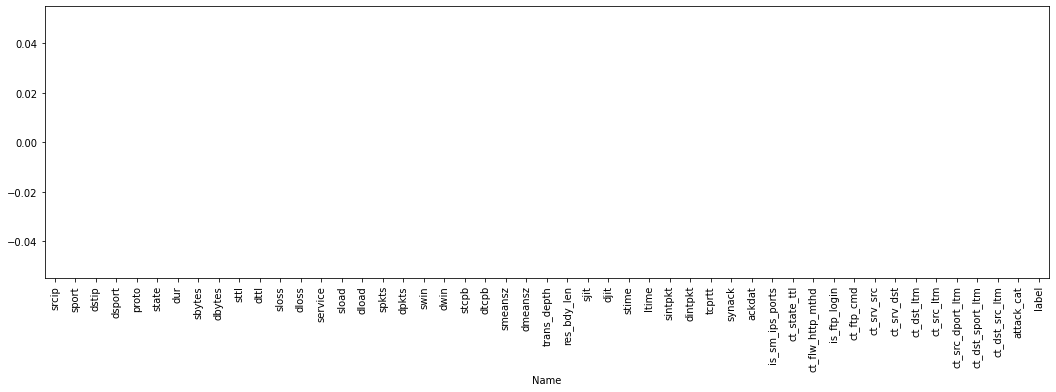

In [24]:
# Visualize missing values 
plt.figure(figsize = (18,5))
all_data.isnull().sum().plot(kind='bar',color=sns.color_palette("husl", 8))

In [25]:
# Compare columns in larger csv files w/ those in partitioned training and test sets
full_cols = set(all_data.columns)
train_cols = set(train.columns)

# Number of columns the two datasets have in common:
print('No. of common columns:', len(train_cols.intersection(full_cols)))

#Columns in training data not in raw CSV's
print(train_cols - full_cols)

# Columns in raw CSV's not in training data
print(full_cols - train_cols)

No. of common columns: 38
{'dmean', 'dinpkt', 'rate', 'sinpkt', 'smean', 'response_body_len'}
{'sintpkt', 'srcip', 'dstip', 'dmeansz', 'dintpkt', 'ltime', 'dsport', 'smeansz', 'res_bdy_len', 'sport', 'stime'}


In [26]:
# Correlation for features in the full dataset.
# I'm seeing similar features to the limited dataset correlation matrix, but the trend is stronger here.
all_data.corr()['label'].sort_values(ascending=False)


Name
label               1.000000
sttl                0.904393
ct_state_ttl        0.873694
ct_dst_src_ltm      0.439916
ct_dst_sport_ltm    0.419056
ct_src_dport_ltm    0.396749
ct_srv_dst          0.386509
ct_srv_src          0.383007
ct_src_ltm          0.343246
ct_dst_ltm          0.339464
ltime               0.275660
stime               0.275660
sload               0.192278
ackdat              0.143443
tcprtt              0.143109
dttl                0.134947
synack              0.122253
sjit                0.020959
sbytes              0.010180
dur                 0.001959
dintpkt            -0.010632
is_sm_ips_ports    -0.015477
sintpkt            -0.019034
ct_flw_http_mthd   -0.026561
res_bdy_len        -0.027339
trans_depth        -0.029041
ct_ftp_cmd         -0.029654
is_ftp_login       -0.032642
sloss              -0.043272
djit               -0.054420
smeansz            -0.065363
dbytes             -0.075543
dloss              -0.095855
dpkts              -0.115947
spkts    

In [27]:
all_data.corr()

Name,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,sload,dload,spkts,...,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,label
Name,,,,,,,,,,,,,,,,,,,,,
dur,1.000000,0.033269,0.086971,-0.003653,0.010708,0.041493,0.087713,-0.014715,-0.022502,0.088082,...,0.007167,0.006411,-0.019276,-0.018429,-0.013797,-0.015871,-0.013103,-0.011308,-0.016087,0.001959
sbytes,0.033269,1.000000,0.047027,-0.008925,0.066423,0.953492,0.051183,-0.020990,-0.006786,0.602840,...,-0.003402,-0.002879,-0.035114,-0.035152,-0.027993,-0.027649,-0.027929,-0.028033,-0.031104,0.010180
dbytes,0.086971,0.047027,1.000000,-0.094181,0.009123,0.115536,0.991342,-0.069986,0.083811,0.727075,...,-0.026904,-0.022704,-0.051501,-0.051996,-0.060283,-0.065256,-0.066204,-0.072021,-0.079876,-0.075543
sttl,-0.003653,-0.008925,-0.094181,1.000000,0.113982,-0.069436,-0.118656,0.280077,-0.246821,-0.150796,...,-0.050610,-0.043435,0.455537,0.458093,0.394223,0.395481,0.456672,0.478093,0.513654,0.904393
dttl,0.010708,0.066423,0.009123,0.113982,1.000000,0.076686,0.013923,-0.219185,-0.022067,0.046316,...,0.028099,0.019652,-0.301396,-0.308916,-0.287295,-0.278726,-0.274834,-0.287738,-0.290141,0.134947
sloss,0.041493,0.953492,0.115536,-0.069436,0.076686,1.000000,0.153328,-0.068925,0.046725,0.725512,...,0.032883,0.027715,-0.081497,-0.083005,-0.079277,-0.079066,-0.085481,-0.087456,-0.094245,-0.043272
dloss,0.087713,0.051183,0.991342,-0.118656,0.013923,0.153328,1.000000,-0.088843,0.108836,0.766469,...,-0.003989,-0.003364,-0.073004,-0.074366,-0.081891,-0.086322,-0.090517,-0.096435,-0.106149,-0.095855
sload,-0.014715,-0.020990,-0.069986,0.280077,-0.219185,-0.068925,-0.088843,1.000000,-0.174604,-0.125043,...,-0.040925,-0.034542,0.473018,0.478605,0.428315,0.418721,0.473234,0.489022,0.512990,0.192278
dload,-0.022502,-0.006786,0.083811,-0.246821,-0.022067,0.046725,0.108836,-0.174604,1.000000,0.167086,...,-0.067986,-0.057428,-0.148099,-0.172706,-0.216306,-0.194039,-0.234258,-0.235888,-0.254661,-0.219710


<AxesSubplot:xlabel='Name', ylabel='Name'>

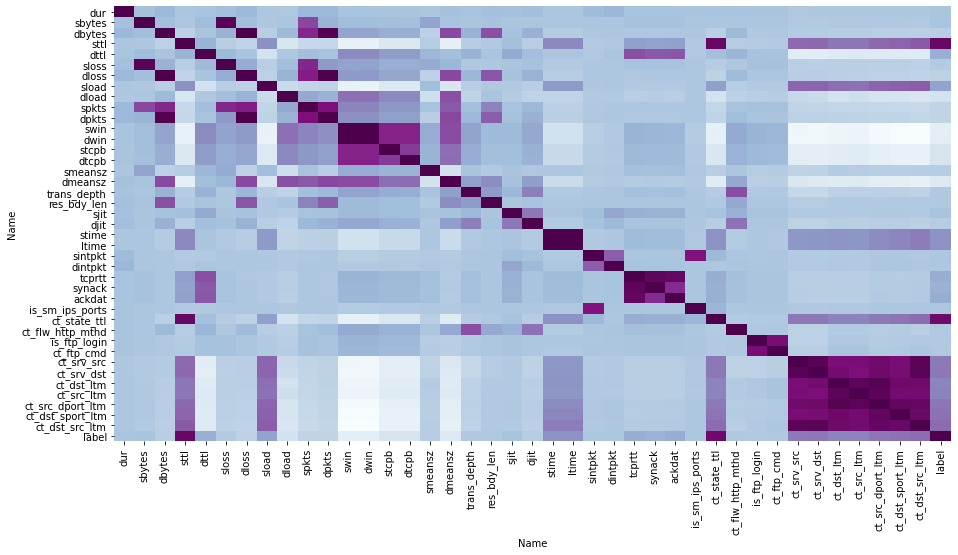

In [28]:
plt.figure(figsize=(15,8))
sns.heatmap(all_data.corr(),
           cmap='BuPu',
           annot=False,
           fmt=".2f",
           annot_kws={'size':16},
           cbar=False)

In [29]:
#Check Correlations among Variables

correlations = all_data.corr()
correlations.replace(1,0).idxmax()

Name
dur                          dintpkt
sbytes                         sloss
dbytes                         dloss
sttl                    ct_state_ttl
dttl                          tcprtt
sloss                         sbytes
dloss                          dpkts
sload                 ct_dst_src_ltm
dload                        dmeansz
spkts                          dpkts
dpkts                          dloss
swin                            dwin
dwin                            swin
stcpb                           dwin
dtcpb                           dwin
smeansz                       sbytes
dmeansz                        dloss
trans_depth         ct_flw_http_mthd
res_bdy_len                   dbytes
sjit                            djit
djit                ct_flw_http_mthd
stime                          ltime
ltime                          stime
sintpkt              is_sm_ips_ports
dintpkt                      sintpkt
tcprtt                        synack
synack                        tcp

In [30]:
#all_data[['sttl','dur']].plot.scatter('sttl','dur')


In [31]:
# Get first observation in training set
train.head(1)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
id,,,,,,,,,,,,,,,,,,,,,
1,0.121478,tcp,-,FIN,6,4,258,172,74.08749,252,...,1,1,0,0,0,1,1,0,Normal,0


In [32]:
## Look at that observation as seen in the raw CSV files.
## Can we identify rate as a combination of existing features?
mask = (all_data.spkts == 6) & (all_data.dbytes==172) & (all_data.dur == 0.121478)
all_data[mask]

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
1087203,149.171.126.14,179,175.45.176.3,33159,tcp,fin,0.121478,258,172,252,...,0,1,1,1,1,1,1,1,normal,0


# One - Hot Encoding
Categorical features should make it into the model, but first should be narrowed to a select few values. For example, the variable `proto` identifies the connection protocol used. There are 135 different protocols in the dataset of 2.5M connections, but only 6 of the protocols occur more than a thousand times. Of those top 6, `tcp` accounts for just under 1.5M connections (~59%) and `udp` for another 990k (~39%).  

Going off the heuristic that more features leads to more model complexity and associated over-fitting challenges, it would be unwise to blindly one-hot-encode this and all other categorical features. If I were training a neural network it might be acceptable, but that's not the case for this project.  

I performed some EDA where I looked at what proprotion of observations with a given categorical feature were anomalies or normal data. From those observations, I think I can reduce the categories for most categorical variables down to 3 or 4 values. For example, `proto` can be reduced to `tcp`, `udp`, `unas`, `arp`, and `other`. Other papers have proposed even fewer: `tcp`, `udp`, and `other`. I've opted to keep `unas` and `arp` because they are almost entirely all attack observations and I want to have that powerful of a contextual feature available.

**Note that features are arranged in alphabetical order after being encoded.** Using the above example, the output of a OHE would be an array with five columns, each column corresponding to `arp`, `other`, `tcp`, `udp`, `unas`, respectively.

# Column-Specific Transformations Experimentation

When data is transformed in the pipeline, the original column is removed and the new data is added to the front row of the existing data structure (array or sparse matrix). The columns are transformed in the order specified in the "columns to transform" parameter in the transformer tuples sent to the ColumnTransformer object. The order in which they occur in the list of transformers also dictates the order in which it appears in the new data structure: the first tuples of transformations are the most to the left in the new structure.

The `remainder` parameter determines whether or not un-transformed columns are retained in the data. Setting it to `"passthrough"` allows me to retain the binary columns and the `label` column and look at the correlation matrix for the transformed data.

Standard scaling is incorporated for all other numeric feature columns after inspections revealed that none of them are normally distributed. Rather, they almost all have a Poisson distribution.

In [33]:
# The columns below, besides 'attack_cat' which acts as an optional label for multiclass, are
# not needed for further modeling after some research online as to what they mean.
droppable_cols = ['srcip', 'sport', 'dstip', 'dsport', 'ltime', 'stime', 'attack_cat']
binary_cols = ['is_sm_ips_ports', 'is_ftp_login']
target_cols = ['label']

In [34]:
# Define the individual steps
ohe_step = ('ohe', OneHotEncoder(sparse=False))
ssc_step = ('std_sclr', StandardScaler())
log_step = ('log10', FunctionTransformer(np.log10))

# Make the step part of a pipeline
ohe_pipe = Pipeline([ohe_step])
ssc_pipe = Pipeline([ssc_step])
log_ssc_pipe = Pipeline([log_step, ssc_step])

# Columns to transform: categorical columns for encoding, numeric feature columns for standardizing
ohe_cols = ['proto', 'state', 'service']
non_ssc_cols = ohe_cols+droppable_cols+binary_cols+target_cols
#ssc_cols = all_data.drop(columns = ohe_cols+droppable_cols+['label']).columns
ssc_cols = [col for col in all_data.columns if col not in non_ssc_cols]

# Transformer input: tuple w/ contents ('name', SomeTransformer(Parameters), columns)
transformer = [
    ('one_hot_encoding', ohe_pipe, ohe_cols),
    ('standard_scaling', ssc_pipe, ssc_cols)
]

In [35]:
# Implementing and testing the column transformer
ct = ColumnTransformer(transformers=transformer, remainder='passthrough')
#ct = ColumnTransformer(transformers=transformer)

In [36]:
# Recreating column labels for one_hot_encoded data
cat_cols = np.concatenate((np.sort(all_data.proto.unique()),
                           np.sort(all_data.state.unique()),
                           np.sort(all_data.service.unique())))

# Combining transformed column labels with non-transformed column labels.
# Order matters here: transformed columns in order, non-transformed features, target column
new_cols =  np.concatenate((cat_cols, ssc_cols, binary_cols, target_cols))

In [37]:
# pd.DataFrame(ct.fit_transform(all_data.drop(columns=['attack_cat']))).head()
# new_data = pd.DataFrame(ct.fit_transform(all_data.drop(columns=droppable_cols)))
# new_data.columns = new_cols